<a href="https://colab.research.google.com/github/syedanida/Transformers-and-NLP/blob/main/Part_3_Building_and_training_a_transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install -q tensorflow tensorflow_text pandas scikit-learn matplotlib

In [2]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.18.0


In [4]:
# Section 1: Define the Transformer Architecture Components
# --------------------------------------------------------
print("\n=== Defining Transformer Architecture Components ===")

# 1.1 Multi-Head Attention Layer
class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads

        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        # Query shape: (batch_size, query_elements, projection_dim)
        # Key shape: (batch_size, key_elements, projection_dim)
        # Value shape: (batch_size, key_elements, projection_dim)

        score = tf.matmul(query, key, transpose_b=True)
        # Scale the dot product
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)

        # Apply softmax to get attention weights
        weights = tf.nn.softmax(scaled_score, axis=-1)

        # Compute the weighted average of the value vectors
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # inputs.shape = [batch_size, sequence_length, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # Create the query, key, and value vectors
        query = self.query_dense(inputs)  # (batch_size, sequence_length, embed_dim)
        key = self.key_dense(inputs)      # (batch_size, sequence_length, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, sequence_length, embed_dim)

        # Reshape for multi-head attention computation
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, sequence_length, projection_dim)
        key = self.separate_heads(key, batch_size)      # (batch_size, num_heads, sequence_length, projection_dim)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, sequence_length, projection_dim)

        # Compute attention for each head
        attention, weights = self.attention(query, key, value)

        # Reshape back to original format
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, sequence_length, num_heads, projection_dim)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, sequence_length, embed_dim)

        # Apply final linear projection
        outputs = self.combine_heads(concat_attention)  # (batch_size, sequence_length, embed_dim)

        return outputs

# 1.2 Position-wise Feed-Forward Network
def feed_forward_network(embed_dim, ff_dim):
    return keras.Sequential(
        [
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ]
    )

# 1.3 Transformer Encoder Layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = feed_forward_network(embed_dim, ff_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        # Multi-head self attention
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection and normalization

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Residual connection and normalization

# 1.4 Token and Position Embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


=== Defining Transformer Architecture Components ===



=== Building the Transformer Text Classification Model ===
Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set size: 20000
Validation set size: 5000
Test set size: 25000
Model created successfully!


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 32)        │       326,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 200, 32)        │         6,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,814 (1.45 MB)

 Trainable params: 378,814 (1.45 MB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 415s 611ms/step - accuracy: 0.4968 - loss: 0.6987 - val_accuracy: 0.4874 - val_loss: 0.6935
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 439s 607ms/step - accuracy: 0.4952 - loss: 0.6939 - val_accuracy: 0.4874 - val_loss: 0.6932
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 391s 621ms/step - accuracy: 0.5041 - loss: 0.6933 - val_accuracy: 0.4874 - val_loss: 0.6937
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 451s 636ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.4874 - val_loss: 0.6937

=== Evaluating the Model ===
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 204ms/step - accuracy: 0.5073 - loss: 0.6931
Test accuracy: 0.5000
782/782 ━━━━━━━━━━━━━━━━━━━━ 158s 199ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12500
           1       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


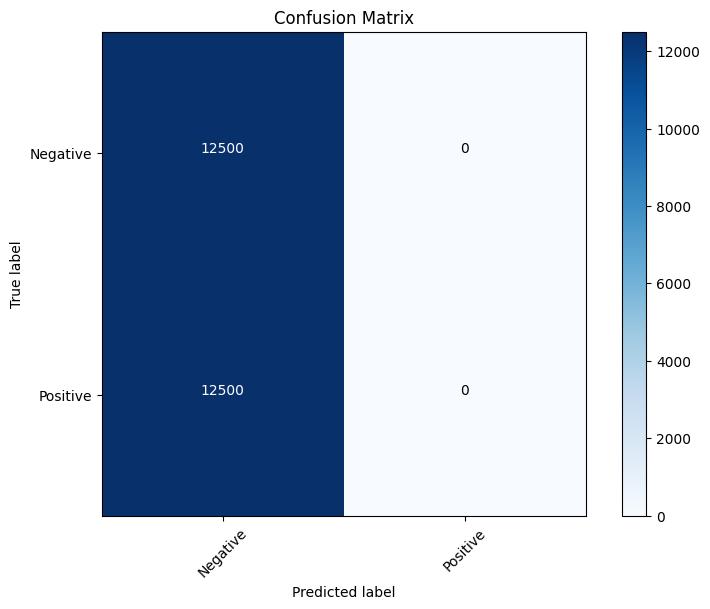

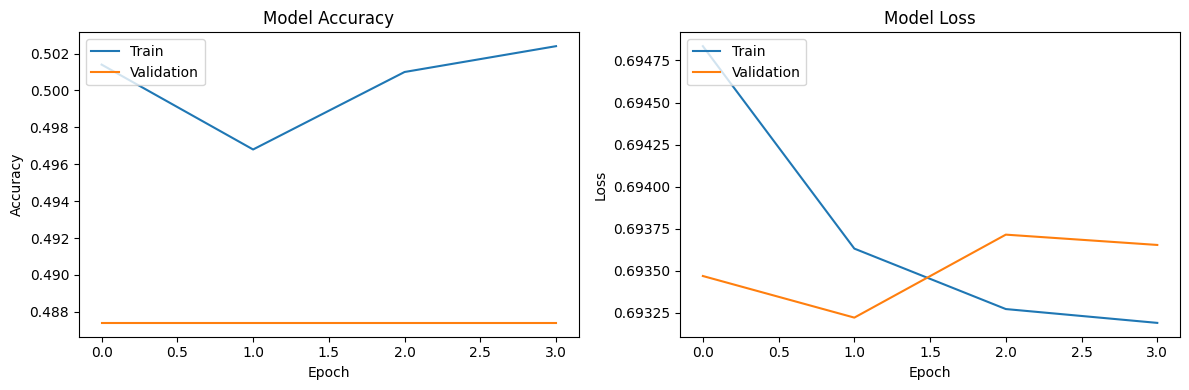

In [5]:
# Section 2: Build the Transformer Text Classification Model
# ---------------------------------------------------------
print("\n=== Building the Transformer Text Classification Model ===")

# Load and prepare the IMDB dataset
print("Loading IMDB dataset...")
max_features = 10000  # Max vocabulary size
max_len = 200  # Sequence length

# Load the IMDB dataset with Keras
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)

# Pad sequences to ensure uniform input shape
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

# Split training data to create a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

# Create the transformer model
def create_transformer_classifier(
    maxlen, vocab_size, embed_dim, num_heads, ff_dim, num_transformer_blocks
):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
embed_dim = 32  # Embedding size for each token
num_heads = 2   # Number of attention heads
ff_dim = 32     # Hidden layer size in feed forward network
num_transformer_blocks = 8  # Number of transformer blocks

# Create and compile the model
model = create_transformer_classifier(
    max_len, max_features, embed_dim, num_heads, ff_dim, num_transformer_blocks
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model created successfully!")
model.summary()

# Train the model
print("\nTraining the model...")
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
    ]
)

# Evaluate the model
print("\n=== Evaluating the Model ===")
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('transformer_confusion_matrix.png')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('transformer_training_history.png')
plt.show()

In [6]:
# Test with new examples
print("\n=== Testing with New Examples ===")

# To test with new examples, we would need to convert text to integers using the same word_index
# used in the IMDB dataset
word_index = keras.datasets.imdb.get_word_index()

def encode_text(text):
    # Add 3 because 0 is reserved for padding, and indices 1,2 are reserved for start and unknown
    encoded = [word_index.get(word.lower(), 2) + 3 for word in text.split()]
    # Truncate or pad to max_len
    if len(encoded) > max_len:
        encoded = encoded[:max_len]
    else:
        encoded = encoded + [0] * (max_len - len(encoded))
    return np.array([encoded])

# Define some new reviews
new_reviews = [
    "This movie was excellent! The acting was incredible and the plot was engaging throughout.",
    "Terrible film. Bad acting, confusing plot, and the ending made no sense.",
    "The movie was okay. Some parts were good, but overall it was just average.",
    "I absolutely loved this film! It's definitely going on my list of favorites.",
    "Waste of time and money. Don't bother watching this disaster."
]

# Predict sentiment for new reviews
print("\nPredictions for new reviews:")
for review in new_reviews:
    encoded_review = encode_text(review)
    prediction = model.predict(encoded_review)[0]
    sentiment = "Positive" if np.argmax(prediction) == 1 else "Negative"
    confidence = prediction[np.argmax(prediction)]

    # Truncate review for display
    display_review = review[:75] + "..." if len(review) > 75 else review
    print(f"Review: {display_review}")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 50)

# Save the model
model.save('transformer_classifier.h5')
print("Model saved as 'transformer_classifier.h5'")


=== Testing with New Examples ===
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Predictions for new reviews:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Review: This movie was excellent! The acting was incredible and the plot was engagi...
Prediction: Negative (Confidence: 0.5014)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Review: Terrible film. Bad acting, confusing plot, and the ending made no sense.
Prediction: Negative (Confidence: 0.5014)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Review: The movie was okay. Some parts were good, but overall it was just average.
Prediction: Negative (Confidence: 0.5014)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Review: I absolutely loved this film! It's definitely going on my list of favorites...
Prediction: Negative (Confidence: 0.5014)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

Review: Waste of time and money. Don't bother watching this disaster.
Prediction: Negative (Confidence: 0.5014)
--------------------------------------------------
Model saved as 'transformer_classifier.h5'
